In [ ]:
# Section 1: Gradient Checking
import numpy as np
from network import Network
from layers import Dense
from activations import Sigmoid, Tanh
from losses import MSE
from optimizer import SGD

# XOR dataset
X = np.array([[0,0],
              [0,1],
              [1,0],
              [1,1]])
y = np.array([[0],
              [1],
              [1],
              [0]])

# Small network for XOR
model = Network([
    Dense(2, 4, init_scale=1),
    Tanh(),
    Dense(4, 1, init_scale=1),
    Sigmoid()
])

loss_fn = MSE()
epsilon = 1e-5

# Forward pass
pred = model.forward(X)
loss = loss_fn.forward(pred, y)

# Backward pass to compute analytical gradients
grad_loss = loss_fn.backward(pred, y)
model.backward(grad_loss)

# Pick first layer weights for demonstration
W = model.layers[0].W
grad_analytic = model.layers[0].dW  # now this should not be None

# Compute numerical gradient
numerical_grad = np.zeros_like(W)
for i in range(W.shape[0]):
    for j in range(W.shape[1]):
        W[i,j] += epsilon
        loss_plus = loss_fn.forward(y, model.forward(X))
        W[i,j] -= 2*epsilon
        loss_minus = loss_fn.forward(y, model.forward(X))
        W[i,j] += epsilon  # reset

        numerical_grad[i,j] = (loss_plus - loss_minus) / (2*epsilon)

# Compare with analytical gradient
print("Analytical Gradient:\n", grad_analytic)
print("Numerical Gradient:\n", numerical_grad)
diff = np.linalg.norm(grad_analytic - numerical_grad) / (np.linalg.norm(grad_analytic) + np.linalg.norm(numerical_grad))
print("Relative Difference:", diff)
if diff < 1e-7:
    print("Gradient check passed!")
else:
    print("Gradient check failed.")


Analytical Gradient:
 [[-0.00133915 -0.02007331 -0.00011771  0.0116412 ]
 [-0.00751128  0.00974218  0.00231917  0.0164194 ]]
Numerical Gradient:
 [[-0.00133915 -0.02007331 -0.00011771  0.0116412 ]
 [-0.00751128  0.00974218  0.00231917  0.0164194 ]]
Relative Difference: 9.340686517374326e-11
Gradient check passed!


In [ ]:
#Section 2: The XOR problem (training and results) using my libraries




# XOR dataset
X = np.array([[0,0],
              [0,1],
              [1,0],
              [1,1]])

y = np.array([[0],
              [1],
              [1],
              [0]])

# Build network: 2 → 4 → 1
#2 input neurons (x1,x2), 4 hidden neurons, 1 output neuron
model = Network([
    Dense(2, 4, init_scale=1),
    #tanh provide non linearity to the 4 hidden neurons
    Tanh(),
    #takes 4 inputs from the hidden layer and outputs 0 or 1
    Dense(4, 1, init_scale=1),
    #sigmoid outputs values between 0 and 1
    Sigmoid()
])

loss_fn = MSE()
optimizer = SGD(lr=0.1)

# Training loop, 5000 iterations
for epoch in range(5000):
    pred = model.forward(X) #y^
    loss = loss_fn.forward(pred, y)
    grad = loss_fn.backward(pred, y) #dL/dy^
    model.backward(grad) #backpropagate through the network
    model.update(optimizer)
#print loss each 500 iterations
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss = {loss:.5f}")

# Final predictions
print("\nFinal Predictions:")
print(model.forward(X))

Epoch 0, Loss = 0.26243
Epoch 500, Loss = 0.19142
Epoch 1000, Loss = 0.04170
Epoch 1500, Loss = 0.01427
Epoch 2000, Loss = 0.00790
Epoch 2500, Loss = 0.00532
Epoch 3000, Loss = 0.00397
Epoch 3500, Loss = 0.00314
Epoch 4000, Loss = 0.00259
Epoch 4500, Loss = 0.00220

Final Predictions:
[[0.02391272]
 [0.95249545]
 [0.95406858]
 [0.05189731]]


In [ ]:
#Section 3: The Autoencoder (training, loss curve, and image visualizations) using your library.
#importing classes from my libraries created in milestone 1
import numpy as np
from network import Network
from layers import Dense
from activations import ReLU, Sigmoid  # or Tanh where appropriate
from losses import MSE, BCE
from optimizer import SGD, Adam



#part 2A: the autoencoder to compress the images
# creating the autoencoder function, it was take input from MNIST dataset
def build_encoder(input_dim=784, latent_dim=64):
    layers = [
        Dense(input_dim, 512, init_scale=0.001),
        ReLU(),
        Dense(512, 256, init_scale=0.001),
        ReLU(),
        Dense(256, 128, init_scale=0.001),
        ReLU(),
        Dense(128, latent_dim, init_scale=0.001)   # no activation here (linear latent)
    ]
    return Network(layers)
#creating the decoder, which we'll use later in calculating the loss(MSE), by subtracting the decoder ouyput to the original image to calculate losses
#decoder will tell us whether or not the cpomressed representation of the image is good or not
def build_decoder(latent_dim=64, output_dim=784):
    layers = [
        Dense(latent_dim, 128, init_scale=0.001),
        ReLU(),
        Dense(128, 256, init_scale=0.001),
        ReLU(),
        Dense(256, 512, init_scale=0.001),
        ReLU(),
        Dense(512, output_dim, init_scale=0.001),
        #ReLU()
        Sigmoid()  # output pixels in range ]0, 1[, we used sigmoid as the pixels' intensities of pixels are normalized [0,1]
    ]
    return Network(layers)

#loading MNIST dataset from tensorflow which has images of digits from 0 to 9
from tensorflow.keras.datasets import mnist
#MNIST has 60,000 images for training, each image is a matrix of 28 rows and 28 columns with pixel intensity from 0 to 255 and 10,000 images for testing
#xtrain is the images and ytrain is the label of the image  (the digit inside the image from 0 to 9)
#some data are for training and some data are for testin, they must be different data to make sure the model didn't just memorize
(X_train, y_train), (X_test, y_test) = mnist.load_data()

#normalize images to be in range of [0,1] instead of [0,255] by dividing each pixel by 255
X_train = X_train.astype(np.float32) / 255.0
X_test  = X_test.astype(np.float32) / 255.0

#flatten images of 784 pixels to row vectors to enter the encoder as neurons,(60000, 28, 28) → (60000, 784) where each row is an image
X_train = X_train.reshape(-1, 784)
X_test  = X_test.reshape(-1, 784)
#after flattening x_train.shape= (60,000,784)while before it was (60000,28,28)

import numpy as np


latent_dim = 64
encoder = build_encoder(latent_dim=latent_dim)
decoder = build_decoder(latent_dim=latent_dim)
loss_fn = MSE()
encoder_optimizer = Adam(lr=0.001)
decoder_optimizer = Adam(lr=0.001)



latent_dim = 64
encoder = build_encoder(latent_dim=latent_dim)
decoder = build_decoder(latent_dim=latent_dim)
loss_fn = MSE()
encoder_optimizer = Adam(lr=0.001)
decoder_optimizer = Adam(lr=0.001)



loss_history = []

for epoch in range(epochs):
    perm = np.random.permutation(len(X_train))
    epoch_loss = 0
    num_batches = 0

    for i in range(0, len(X_train), batch_size):
        idx = perm[i:i+batch_size]
        x_batch = X_train[idx]

        # Forward
        latent = encoder.forward(x_batch)
        reconstructed = decoder.forward(latent)

        # Loss
        loss = loss_fn.forward(reconstructed, x_batch)
        epoch_loss += loss
        num_batches += 1

        # Backward
        grad = loss_fn.backward(reconstructed, x_batch)
        grad = decoder.backward(grad)
        encoder.backward(grad)

        # Update
        decoder_optimizer.step(decoder.layers)
        encoder_optimizer.step(encoder.layers)

    epoch_loss /= num_batches
    loss_history.append(epoch_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")
    #plotting the loss curve
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(loss_history, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Loss (MSE)")
plt.title("Autoencoder Training Loss Curve")
plt.grid(True)
plt.show()


    #visual representation of 5 original images in the top row and 5 recontructed images after the encoder in the bottom row to make sure that the encoder is correct
import matplotlib.pyplot as plt

def show_reconstructions(encoder, decoder, X, n=5):
    idx = np.random.choice(len(X), n)
    originals = X[idx]
    recon = decoder.forward(encoder.forward(originals))



    plt.figure(figsize=(10,4))
    for i in range(n):
        # original
        plt.subplot(2, n, i+1)
        plt.imshow(originals[i].reshape(28,28), cmap='gray')
        plt.axis('off')

        # reconstructed
        plt.subplot(2, n, n+i+1)
        plt.imshow(recon[i].reshape(28,28), cmap='gray')
        plt.axis('off')

    plt.show()

#actually calling the function
show_reconstructions(encoder, decoder, X_test, n=5)




Epoch 1/40, Loss: 0.0842
Epoch 2/40, Loss: 0.0608
Epoch 3/40, Loss: 0.0525
Epoch 4/40, Loss: 0.0479
Epoch 5/40, Loss: 0.0432
Epoch 6/40, Loss: 0.0392
Epoch 7/40, Loss: 0.0363
Epoch 8/40, Loss: 0.0347
Epoch 9/40, Loss: 0.0335
Epoch 10/40, Loss: 0.0326
Epoch 11/40, Loss: 0.0319
Epoch 12/40, Loss: 0.0310
Epoch 13/40, Loss: 0.0298
Epoch 14/40, Loss: 0.0287
Epoch 15/40, Loss: 0.0277
Epoch 16/40, Loss: 0.0271
Epoch 17/40, Loss: 0.0263
Epoch 18/40, Loss: 0.0254
Epoch 19/40, Loss: 0.0245
Epoch 20/40, Loss: 0.0239
Epoch 21/40, Loss: 0.0231
Epoch 22/40, Loss: 0.0223
Epoch 23/40, Loss: 0.0217
Epoch 24/40, Loss: 0.0211
Epoch 25/40, Loss: 0.0207
Epoch 26/40, Loss: 0.0203
Epoch 27/40, Loss: 0.0200
Epoch 28/40, Loss: 0.0196
Epoch 29/40, Loss: 0.0194
Epoch 30/40, Loss: 0.0190
Epoch 31/40, Loss: 0.0187
Epoch 32/40, Loss: 0.0183
Epoch 33/40, Loss: 0.0179
Epoch 34/40, Loss: 0.0176
Epoch 35/40, Loss: 0.0172
Epoch 36/40, Loss: 0.0168
Epoch 37/40, Loss: 0.0165


(60000, 64)
(10000, 64)
Test accuracy: 0.9531


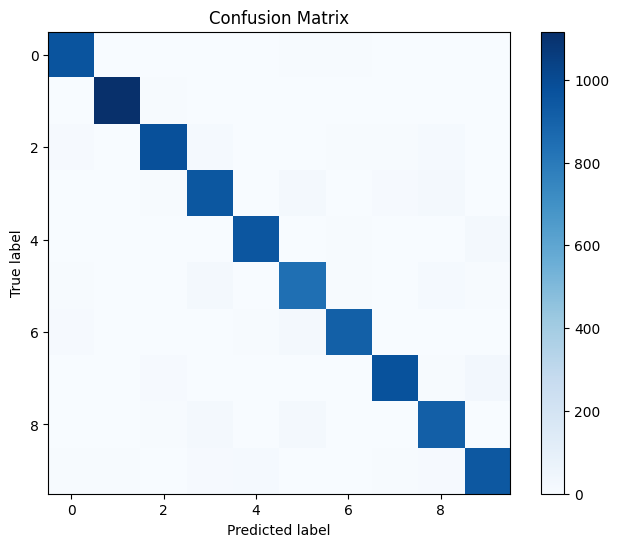

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.99      0.98      0.99      1135
           2       0.96      0.95      0.95      1032
           3       0.92      0.94      0.93      1010
           4       0.97      0.97      0.97       982
           5       0.92      0.94      0.93       892
           6       0.97      0.95      0.96       958
           7       0.97      0.94      0.96      1028
           8       0.93      0.94      0.93       974
           9       0.94      0.93      0.94      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



In [6]:
#Section 4: The Latent Space SVM Classification (feature extraction, SVM training, and evaluation metrics/confusion matrix).

#part 2B latent space classification, we need apply SVN on the latent vector(32) where these 32 numbers are the features  and predict the digits from 0 to 9
# Extract latent features, z represents latent representation which has 32 values instead of 78 ones
#ztrain and ztest are the output of the encoder where xtrain and xtest are the inputs
Z_train = encoder.forward(X_train)  #shape:(60000,32)
Z_test  = encoder.forward(X_test)   #shape:(10000,32)

#printing to make sure that ztrain and ztest have 32 values (compressed after the encoder) taht represents the learned features from the images
print(Z_train.shape)
print(Z_test.shape)


#SVM
from sklearn.svm import SVC

svm = SVC(kernel='rbf')   #rbf is standard and works well
#training SVM by giving it the latent features of the images from the encoder and their true labels, no training loop needed just this line
#SVM trains by calculating the error between feature vector and true labels after we made sure the encoder extracts features with decreasing loss
svm.fit(Z_train, y_train)


#predicted digit for each image
y_pred = svm.predict(Z_test)
#evaluating accuarccy of the model
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy:", accuracy)
#confusion matrix shows wich digits are confused
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.show()
#classification report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

In [ ]:
#Section 5: The TensorFlow/Keras implementations and comparisons.
import tensorflow as tf
import numpy as np

# XOR dataset
X = np.array([[0,0],[0,1],[1,0],[1,1]], dtype=np.float32)
y = np.array([[0],[1],[1],[0]], dtype=np.float32)

# XOR model
xor_model = tf.keras.Sequential([
    tf.keras.layers.Dense(4, activation='tanh', input_shape=(2,)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

xor_model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),
    loss='mse'
)

# Train
xor_model.fit(X, y, epochs=500, verbose=0)

# Test
pred = xor_model.predict(X)
print("XOR predictions:\n", pred)
latent_dim = 128

# Encoder
encoder = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(784,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(latent_dim)
])

# Decoder
decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(latent_dim,)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(784, activation='sigmoid')
])

# Autoencoder
autoencoder = tf.keras.Sequential([encoder, decoder])

autoencoder.compile(
    optimizer='adam',
    loss='mse'
)
history = autoencoder.fit(
    X_train, X_train,
    epochs=20,
    batch_size=256,
    validation_data=(X_test, X_test),
    verbose=1
)
final_loss = history.history['loss'][-1]
print("Final reconstruction loss (Keras):", final_loss)




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
XOR predictions:
 [[0.4277513 ]
 [0.5894922 ]
 [0.49505532]
 [0.5218849 ]]
Epoch 1/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 0.0756 - val_loss: 0.0223
Epoch 2/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - loss: 0.0196 - val_loss: 0.0142
Epoch 3/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - loss: 0.0135 - val_loss: 0.0112
Epoch 4/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - loss: 0.0107 - val_loss: 0.0091
Epoch 5/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0091 - val_loss: 0.0079
Epoch 6/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - loss: 0.0079 - val_loss: 0.0071
Epoch 7/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - loss: 0.0071 - val_loss: 0.0066
Epoch 8/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - loss: 0.0064 - val_loss: 0.0060
Epoch 9/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0060 - val_loss: 0.0056
Epoch 10/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - loss: 0.0056 - val_loss: 0.0052
Epoch 11

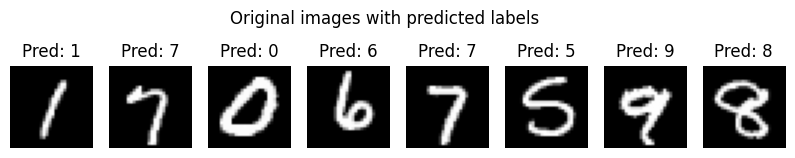

In [9]:
#visulaization section, i'll five it the image and it'll predict the digit
#finaltest


def show_predictions(encoder, classifier, X, y, n=5):
    idx = np.random.choice(len(X), n, replace=False)
    X_samples = X[idx]
    y_true = y[idx]

    # Encode images
    Z = encoder.forward(X_samples)

    # Predict using SVM
    y_pred = classifier.predict(Z)

    plt.figure(figsize=(10, 2))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(X_samples[i].reshape(28,28), cmap='gray')
        plt.title(f"Pred: {y_pred[i]}")
        plt.axis('off')

    plt.suptitle("Original images with predicted labels")
    plt.show()
show_predictions(encoder, svm, X_test, y_test, n=8)